In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!pip install -q datasets accelerate evaluate

# 데이터셋 준비

In [ ]:
import os
import json
import pandas as pd

# 1. 데이터 경로(여기서는 패션 아이템 리뷰만 사용)
data_dir = "/content/drive/Shareddrives/스프린트(AI) 드라이브/트랙 Master 폴더/스프린트 미션 및 모범답안/data/review-sentiment-analysis/쇼핑몰/01. 패션"

# 2. JSON 파일 경로 수집
json_paths = []
for root, _, files in os.walk(data_dir):
    for file in files:
        if file.endswith(".json"):
            json_paths.append(os.path.join(root, file))

# 3. JSON 파싱 및 필요한 데이터(GeneralPolarity, RawText) 수집
data = []

for path in json_paths:
    with open(path, 'r', encoding='utf-8') as f:
        try:
            items = json.load(f)
            for item in items:
                polarity = item.get("GeneralPolarity", None)
                text = item.get("RawText", None)

                if polarity is not None and text:  # 둘 다 있어야 추가
                    polarity = int(polarity)
                    if polarity in [-1, 0, 1]:
                        data.append({
                            "text": text,
                            "label": polarity + 1  # -1 → 0, 0 → 1, 1 → 2
                        })
        except Exception:
            continue  # 형식 이상한 파일은 무시하고 넘어감

# 4. 데이터프레임으로 변환
df = pd.DataFrame(data)
df = df.dropna().drop_duplicates()

print(df["label"].value_counts())

label
2    26451
0     9264
1     8683
Name: count, dtype: int64


In [ ]:
from datasets import Dataset

dataset = Dataset.from_pandas(df)
dataset = dataset.train_test_split(test_size=0.2, seed=42)

In [ ]:
from transformers import AutoTokenizer

model_name = "beomi/KcELECTRA-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)


def preprocess(example):
    tokenized = tokenizer(
        example["text"],
        truncation=True,
        padding="max_length",
        max_length=128
    )
    tokenized["text"] = example["text"]
    return tokenized


tokenized_dataset = dataset.map(preprocess, batched=True)
tokenized_dataset = tokenized_dataset.rename_column("label", "labels")
tokenized_dataset.set_format(
    type="torch",
    columns=["text", "input_ids", "attention_mask", "labels"],
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Map:   0%|          | 0/35518 [00:00<?, ? examples/s]

Map:   0%|          | 0/8880 [00:00<?, ? examples/s]

# Full Fine-Tuning

In [ ]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
import evaluate
import torch


def create_trainer(model, training_args):
    accuracy = evaluate.load("accuracy")

    def compute_metrics(eval_pred):
        logits, labels = eval_pred
        preds = torch.argmax(torch.tensor(logits), dim=1)
        return accuracy.compute(predictions=preds, references=labels)

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_dataset["train"],
        eval_dataset=tokenized_dataset["test"],
        compute_metrics=compute_metrics,
    )

    return trainer


num_epochs = 2
batch_size = 64
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epochs,
    report_to="none",
)

model_ft = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)
trainer_ft = create_trainer(model_ft, training_args)

trainer_ft.train()

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.381500,0.300082,0.880631
2,0.243000,0.279377,0.889640


TrainOutput(global_step=1110, training_loss=0.3028328990077113, metrics={'train_runtime': 367.2746, 'train_samples_per_second': 193.414, 'train_steps_per_second': 3.022, 'total_flos': 4672631185431552.0, 'train_loss': 0.3028328990077113, 'epoch': 2.0})

In [ ]:
import shutil
from google.colab import files

def save_and_download_model(trainer, tokenizer, model_path):
    trainer.save_model(model_path)
    tokenizer.save_pretrained(model_path)

    shutil.make_archive(model_path, "zip", model_path)
    files.download(f"{model_path}.zip")


save_and_download_model(trainer_ft, tokenizer, "full_finetuning")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
def get_predictions_and_labels(trainer, dataset):
    predictions = trainer.predict(dataset)
    pred_labels = torch.argmax(torch.tensor(predictions.predictions), dim=1)
    true_labels = predictions.label_ids

    return pred_labels, true_labels


pred_labels, true_labels = get_predictions_and_labels(trainer_ft, tokenized_dataset["test"])

🎯 테스트 정확도: 88.96%


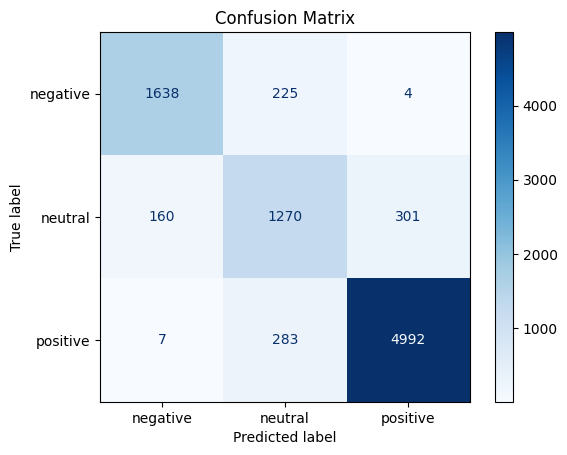

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def print_acc_and_confusion_matrix(true_labels, pred_labels):
    # 정확도
    test_accuracy = accuracy_score(true_labels, pred_labels)
    print(f"🎯 테스트 정확도: {test_accuracy * 100:.2f}%")

    # Confusion Matrix 출력
    cm = confusion_matrix(true_labels, pred_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["negative", "neutral", "positive"])
    disp.plot(cmap="Blues", values_format='d')
    plt.title("Confusion Matrix")
    plt.show()


print_acc_and_confusion_matrix(true_labels, pred_labels)

In [ ]:
def print_samples(dataset, true_labels, pred_labels, num_samples=5):
    label_to_text = {0: "negative", 1: "neutral", 2: "positive"}

    # 정답/예측 샘플 출력
    print("\n✅ 예측 결과 샘플:")
    for i in range(num_samples):
        print("📝 원문:", dataset[i]["text"])
        print("✅ 실제:", label_to_text[dataset[i]["label"]], "🔮 예측:", label_to_text[pred_labels[i].item()])
        print("-" * 40)

    # 오분류된 샘플 출력
    print("\n\n❌ 예측이 틀린 샘플:")
    wrong_indices = [i for i, (pred, true) in enumerate(zip(pred_labels, true_labels)) if pred != true]
    for i in wrong_indices[:num_samples]:
        print("📝 원문:", dataset[i]["text"])
        print("✅ 실제:", label_to_text[dataset[i]["label"]], "🔮 예측:", label_to_text[pred_labels[i].item()])
        print("-" * 40)


num_samples = 5
print_samples(dataset["test"], true_labels, pred_labels, num_samples)


✅ 예측 결과 샘플:
📝 원문: 가격대비 품질 아주 좋아요. 소매길이가 아주 조금만 길었음 좋았을거 같아요.
✅ 실제: neutral 🔮 예측: neutral
----------------------------------------
📝 원문: 한 번 입었는데 보풀이 막 생깁니다. 싼 값 한다고 해야하나...
✅ 실제: negative 🔮 예측: negative
----------------------------------------
📝 원문: 너무 맘에 들어요 여름청바지라는 말이 딱 맞을정도로 얇고 보이핏이라서 그런지 엉밑살도 감춰주고 좋아요!
✅ 실제: positive 🔮 예측: positive
----------------------------------------
📝 원문: 여름에 더워서 청바지 잘 못입었는데 에어리 쿨 진은 정말 얇고 시원한 촉감이여요. 대만족 입니다.
✅ 실제: positive 🔮 예측: positive
----------------------------------------
📝 원문: 아들이 시원한 신발 원해서 구매했는데  아주 좋아하네요 싸이즈도 맞고 가볍고 딱입니다 아주 잘신겠어요 대박
✅ 실제: positive 🔮 예측: positive
----------------------------------------


❌ 예측이 틀린 샘플:
📝 원문: 다 괜찮은데 처음 신고 잠깐 외출...집에 들어올때 아이들이 하는 말 엄마 뒤꿈치가 시꺼멓다고 하네요..신발이 색이 묻어 나네요..그것 빼고는 편안한고 괜찮은데....^^
✅ 실제: positive 🔮 예측: neutral
----------------------------------------
📝 원문: 사이즈가 약간 작은듯 하지만 디자인 괜찮습니다
✅ 실제: neutral 🔮 예측: positive
----------------------------------------
📝 원문: 신축성이 완전 좋아요.  33사이즈인데 32사이즈가 잘 맞네요. 저렴하고 배송도 빠릅니다.
✅ 실제:

# PEFT

In [ ]:
from peft import get_peft_model, LoraConfig, TaskType

peft_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    inference_mode=False,
    r=8,
    lora_alpha=16,
    lora_dropout=0.1,
)

model_peft = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)
model_peft = get_peft_model(model_peft, peft_config)
model_peft.print_trainable_parameters()

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 887,811 || all params: 109,971,462 || trainable%: 0.8073


In [ ]:
num_epochs = 5
batch_size = 64
training_args_peft = TrainingArguments(
    output_dir="./results_peft",
    eval_strategy="epoch",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epochs,
    report_to="none",
)

trainer_peft = create_trainer(model_peft, training_args_peft)
trainer_peft.train()

No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.591800,0.409183,0.819257
2,0.413200,0.396220,0.841329
3,0.373500,0.360871,0.852928
4,0.367500,0.354756,0.856194
5,0.349900,0.350820,0.856644


TrainOutput(global_step=2775, training_loss=0.41263872851122607, metrics={'train_runtime': 688.6322, 'train_samples_per_second': 257.888, 'train_steps_per_second': 4.03, 'total_flos': 1.18026657245952e+16, 'train_loss': 0.41263872851122607, 'epoch': 5.0})

In [ ]:
save_and_download_model(trainer_peft, tokenizer, "peft")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

🎯 테스트 정확도: 85.66%


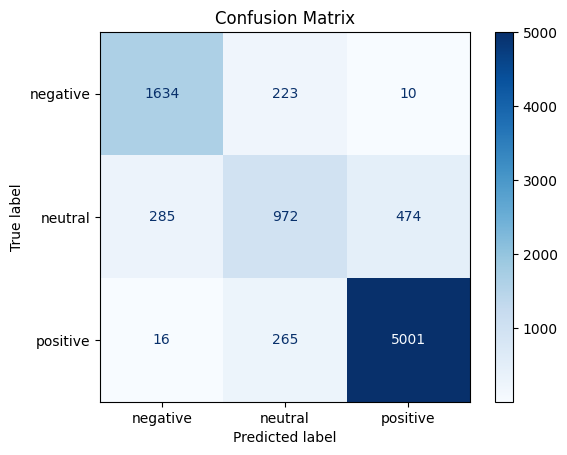


✅ 예측 결과 샘플:
📝 원문: 가격대비 품질 아주 좋아요. 소매길이가 아주 조금만 길었음 좋았을거 같아요.
✅ 실제: neutral 🔮 예측: positive
----------------------------------------
📝 원문: 한 번 입었는데 보풀이 막 생깁니다. 싼 값 한다고 해야하나...
✅ 실제: negative 🔮 예측: negative
----------------------------------------
📝 원문: 너무 맘에 들어요 여름청바지라는 말이 딱 맞을정도로 얇고 보이핏이라서 그런지 엉밑살도 감춰주고 좋아요!
✅ 실제: positive 🔮 예측: positive
----------------------------------------
📝 원문: 여름에 더워서 청바지 잘 못입었는데 에어리 쿨 진은 정말 얇고 시원한 촉감이여요. 대만족 입니다.
✅ 실제: positive 🔮 예측: positive
----------------------------------------
📝 원문: 아들이 시원한 신발 원해서 구매했는데  아주 좋아하네요 싸이즈도 맞고 가볍고 딱입니다 아주 잘신겠어요 대박
✅ 실제: positive 🔮 예측: positive
----------------------------------------


❌ 예측이 틀린 샘플:
📝 원문: 가격대비 품질 아주 좋아요. 소매길이가 아주 조금만 길었음 좋았을거 같아요.
✅ 실제: neutral 🔮 예측: positive
----------------------------------------
📝 원문: 다 괜찮은데 처음 신고 잠깐 외출...집에 들어올때 아이들이 하는 말 엄마 뒤꿈치가 시꺼멓다고 하네요..신발이 색이 묻어 나네요..그것 빼고는 편안한고 괜찮은데....^^
✅ 실제: positive 🔮 예측: neutral
----------------------------------------
📝 원문: 사이즈가 약간 작은듯 하지만 디자인 괜찮습니다
✅ 실제: neutra

In [ ]:
pred_labels, true_labels = get_predictions_and_labels(trainer_peft, tokenized_dataset["test"])

print_acc_and_confusion_matrix(true_labels, pred_labels)

num_samples = 5
print_samples(dataset["test"], true_labels, pred_labels, num_samples)